<a href="https://colab.research.google.com/github/barywhyte/analytics/blob/master/A_B_Testing_and_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Hypothesis A/B Testing 

In [0]:
# import important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from scipy.stats import norm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn   #ignore warnings from sklearn and seaborn

### Load Data from Github

In [0]:
data = pd.ExcelFile("https://github.com/10acad/piq2019/blob/master/data/UdacityABtesting.xlsx?raw=true")
control = pd.read_excel(data, 'Control')
experiment = pd.read_excel(data, 'Experiment')

### Examine Data

In [524]:
control.head()

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7723,687,134.0,70.0
1,"Sun, Oct 12",9102,779,147.0,70.0
2,"Mon, Oct 13",10511,909,167.0,95.0
3,"Tue, Oct 14",9871,836,156.0,105.0
4,"Wed, Oct 15",10014,837,163.0,64.0


In [525]:
experiment.head()

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7716,686,105.0,34.0
1,"Sun, Oct 12",9288,785,116.0,91.0
2,"Mon, Oct 13",10480,884,145.0,79.0
3,"Tue, Oct 14",9867,827,138.0,92.0
4,"Wed, Oct 15",9793,832,140.0,94.0


### Quiz Qustions

**How many days of observation are there in the control and experimental group?**

In [526]:
len(control['Date'].unique())

37

In [527]:
len(experiment['Date'].unique())

37

**How many missing values are there in each of the control and experiments data?**

In [0]:
def missing_data(data):
  missing = data.isnull().sum()
  missing = missing[missing > 0]
  return missing

In [529]:
print(missing_data(control))

Enrollments    14
Payments       14
dtype: int64


In [530]:
print(missing_data(experiment))

Enrollments    14
Payments       14
dtype: int64


**What is the underlying statistical probability distribution for a data collected from this type of experiments? Why?**

In [0]:
def distribution(data):
  data['Non-Enrollements'] = data['Clicks'] - data['Enrollments']
  return data

In [532]:
distribution(control.head())

,Date,Pageviews,Clicks,Enrollments,Payments,Non-Enrollements
0,"Sat, Oct 11",7723,687,134.0,70.0,553.0
1,"Sun, Oct 12",9102,779,147.0,70.0,632.0
2,"Mon, Oct 13",10511,909,167.0,95.0,742.0
3,"Tue, Oct 14",9871,836,156.0,105.0,680.0
4,"Wed, Oct 15",10014,837,163.0,64.0,674.0


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


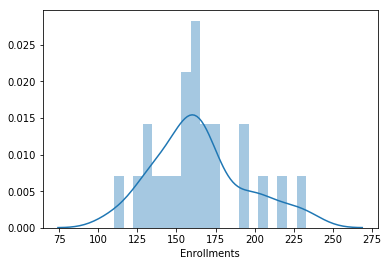

In [533]:
sns.distplot(control['Enrollments'], bins=20);

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


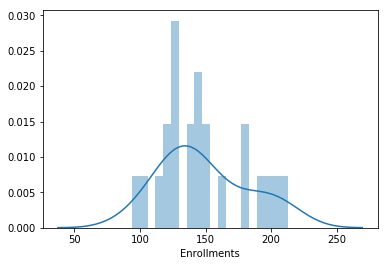

In [534]:
sns.distplot(experiment['Enrollments'], bins=20);

## Metric Analysis

### Two types of metrics are necessary for this project:
      1. Invariate Metrics : which seek to make sure that the data collection method as well
      as the presentation of changes to larger population sample is not inherently wrong.
      Examples of this are : (1) Number of cookies in course overview page. (2) Number of 
      Clicks on Free Trial Button and (3) Free Trial button Click-Through-Probability
      
      2. Evaluation Metrics : These are used to measure the performance of the test and its 
      relevance to to business goal that we aim to achieve (in this case, a better user's
      experience).
      Examples are : (1) Gross conversion (no. of enrolled/total clicks on trial button)
                                        (2) Retention (total paid/no. of enrolled)
                                        (3) Net conversion (total paid/total clicks on trial button)
                      
    **source** : https://docs.google.com/document/u/1/d/1aCquhIqsUApgsxQ8-
    SQBAigFDcfWVVohLEXcV6jWbdI/pub?embedded=True

### Estimating the baseline values of metrics

Baseline values source : https://docs.google.com/spreadsheets/d/1MYNUtC47Pg8hdoCjOXaHqF-thheGpUshrFA21BAJnNc/edit#gid=0

In [535]:
#Let's place this estimators into a dictionary for later use
baseline = {"Cookies" : 40000, "Clicks" : 3200, "Enrollments" : 660, "CTP" : 0.08, "GConversion" : 0.20625, "Retention" : 0.53, "NConversion" : 0.109313}
baseline

{'CTP': 0.08,
 'Clicks': 3200,
 'Cookies': 40000,
 'Enrollments': 660,
 'GConversion': 0.20625,
 'NConversion': 0.109313,
 'Retention': 0.53}

### Scaling collected data to say, 5000 cookies. This is representative sample of the entire data population.

In [536]:
baseline["Cookies"] = 5000
baseline["Clicks"]=baseline["Clicks"]*(5000/40000)
baseline["Enrollments"]=baseline["Enrollments"]*(5000/40000)
baseline

{'CTP': 0.08,
 'Clicks': 400.0,
 'Cookies': 5000,
 'Enrollments': 82.5,
 'GConversion': 0.20625,
 'NConversion': 0.109313,
 'Retention': 0.53}

### I will focus on the analysis of the Evaluation metrics since the project's aim is to measure performance of the A/B test.

STANDARD DEVIATION EVALUATION.

$$ std = \sqrt{p*(1-p)/n} $$

 
where p = probability of the event under consideration, and 
            n = sample data    

**Gross Conversion** : no. of enrolled/total clicks on trial button. That is, probability of enrollment given a click.

In [537]:
G_Conversion={}
# let G_Conversion["sd"] = standard deviation Gross Conversion metric 
G_Conversion["d_min"] = 0.01 #given
G_Conversion["n"]  = baseline["Clicks"]
G_Conversion["p"] = baseline["Enrollments"]/baseline["Clicks"]
G_Conversion["sd"] = round(sqrt((G_Conversion["p"]*(1-G_Conversion["p"]))/G_Conversion["n"]), 5)
G_Conversion["sd"]

0.02023

**Retention :**  total number of  paid users/total number of enrolled users. That is, probability of payment given enrollment.

In [538]:
retention = {}
retention["d_min"]=0.01 # given
retention["p"]=baseline["Retention"]
retention["n"]=baseline["Enrollments"]
retention["sd"]=round(sqrt((retention["p"]*(1-retention["p"]))/retention["n"]), 5)
retention["sd"]

0.05495

**Net Conversion :** total number of  paid users/total number of clicks on trial button. That is, probability of payment, given click.

In [539]:
N_Conversion = {}
N_Conversion["d_min"]=0.0075
N_Conversion["p"]=baseline["NConversion"]
N_Conversion["n"]=baseline["Clicks"]
N_Conversion["sd"]=round(sqrt((N_Conversion["p"]*(1-N_Conversion["p"]))/N_Conversion["n"]), 5)
N_Conversion["sd"]

0.0156

#### Calculating sample size per metric : I used an external tool in place on complex formula to get this sample size
> http://www.evanmiller.org/ab-testing/sample-size.html

                  Gross Conversion minimum detectable effect = 0.01
                  Retention minimum detectable effect = 0.01
                  Net Conversion minimum detectable effect = 0.0075

**Sample size for Gross Conversion**

In [540]:
G_Conversion["SampleSize"] = 25835
G_Conversion

{'SampleSize': 25835, 'd_min': 0.01, 'n': 400.0, 'p': 0.20625, 'sd': 0.02023}

                            This shows we need at least 25,835 cookies to click the Free Trial button
                            per group! Going back to the scaling above, this translate to 
                            need G_Conversion["SampSize"]*12.5 = 322,938 pageviews, per group. This is 
                            working in percentage. Finally, the total amount of samples per the Gross 
                            Conversion metric for both groups is:

In [541]:
G_Conversion["SampleSize"] = G_Conversion['SampleSize']*12.5*2
G_Conversion["SampleSize"]

645875.0

**Sample size for Retention**

In [542]:
retention["SampleSize"] = 39115
retention["SampleSize"]

39115

                 This means we need 39,115 of those who enrolled to pay per group. We need to convert
                 this to cookies who clicked, and then to cookies who viewed the page. For both 
                 groups, we simply multiply result by 2

In [543]:
retention["SampleSize"] = retention["SampleSize"]*12.5*20.625*2
retention["SampleSize"]

20168671.875

                    This is over 20million page views! If we are collecting 40,000 views per day as 
                    shown in the baseline for cookies, we will need 20168672/40000 = 504 days to 
                    collect this views. Not practical. 

**Sample Size for Net Conversion**

In [544]:
N_Conversion["SampleSize"] = 27413
N_Conversion["SampleSize"]

27413

In [545]:
N_Conversion["SampleSize"] = N_Conversion["SampleSize"]*12.5*2
N_Conversion["SampleSize"]

685325.0

                   This is more than what we got for Gross Conversion, so this is ok.

### Understanding Changes between the Control and Experiment groups with regard to our Evaluation Metrics to make sure the difference is there

In [0]:

def getzscore(alpha):
    return norm.ppf(alpha)

**Gross Conversion Metric - number of enrollments divided by number of clicks**

In [547]:
# extract the total clicks without missing values
alpha =0.05
control_clicks = control["Clicks"].loc[control["Enrollments"].notnull()].sum()
experiment_clicks = experiment["Clicks"].loc[experiment["Enrollments"].notnull()].sum()

control_enrollments = control["Enrollments"].sum()
experiment_enrollments = experiment["Enrollments"].sum()

control_gross = control_enrollments/control_clicks
experiment_gross = experiment_enrollments/experiment_clicks
pooled_gross = (control_enrollments + experiment_enrollments)/(control_clicks + experiment_clicks)
pooled_gross_sd = sqrt(pooled_gross*(1-pooled_gross)*(1/control_clicks+1/experiment_clicks))
gross = round(getzscore(1-alpha/2)*pooled_gross_sd,4)
gross_diff = round(experiment_gross - control_gross, 4)
print("The change due to this experimentation is", gross_diff*100,"%")
print("Confidence Interval: [",gross_diff - gross,",",gross_diff + gross,"]")
#print ("The change is statistically significant if the CI doesn't include 0. In that case, it is practically significant if",-GC["d_min"],"is not in the CI as well.")

The change due to this experimentation is -2.06 %
Confidence Interval: [ -0.0292 , -0.012 ]


               According to the above, we have a change of -2.06%. Gross Conversion rate of the 
               experiment group has decreased by 2% and this change was significant

**Net Conversion Metric - number of payents divided by number of clicks**

In [548]:
control_payments = control["Payments"].sum()
experiment_payments = experiment["Payments"].sum()

control_net = control_payments/control_clicks
experiment_net = experiment_payments/experiment_clicks
pooled_net = (control_payments + experiment_payments)/(control_clicks + experiment_clicks)
pooled_net_sd = sqrt(pooled_net*(1-pooled_net)*(1/control_clicks+1/experiment_clicks))
net = round(getzscore(1-alpha/2)*pooled_net_sd, 4)
net_diff = round(experiment_net - control_net, 4)
print("The change due to this experimentation is", net_diff*100,"%")
print("Confidence Interval: [",net_diff - net,",", net_diff + net,"]")
#print ("The change is statistically significant if the CI doesn't include 0. In that case, it is practically significant if",-GC["d_min"],"is not in the CI as well.")

The change due to this experimentation is -0.49 %
Confidence Interval: [ -0.0116 , 0.0018000000000000004 ]


             This change is less than  0.5%, a very small decrease which is
             not statistically significant

# Machine Learning

###Data analysis tasks:

In [549]:
control['id'] = 'control'
control.head()

,Date,Pageviews,Clicks,Enrollments,Payments,id
0,"Sat, Oct 11",7723,687,134.0,70.0,control
1,"Sun, Oct 12",9102,779,147.0,70.0,control
2,"Mon, Oct 13",10511,909,167.0,95.0,control
3,"Tue, Oct 14",9871,836,156.0,105.0,control
4,"Wed, Oct 15",10014,837,163.0,64.0,control


In [550]:
experiment['id'] = 'experiment'
experiment.head()

,Date,Pageviews,Clicks,Enrollments,Payments,id
0,"Sat, Oct 11",7716,686,105.0,34.0,experiment
1,"Sun, Oct 12",9288,785,116.0,91.0,experiment
2,"Mon, Oct 13",10480,884,145.0,79.0,experiment
3,"Tue, Oct 14",9867,827,138.0,92.0,experiment
4,"Wed, Oct 15",9793,832,140.0,94.0,experiment


**Combine the control_tbl and experiment_tbl, adding an “id” column indicating if the data was part of the experiment or not**

In [551]:
com_data = pd.concat([control, experiment], ignore_index=True, join='inner')
print(com_data.shape)
com_data.head()

(74, 6)


,Date,Pageviews,Clicks,Enrollments,Payments,id
0,"Sat, Oct 11",7723,687,134.0,70.0,control
1,"Sun, Oct 12",9102,779,147.0,70.0,control
2,"Mon, Oct 13",10511,909,167.0,95.0,control
3,"Tue, Oct 14",9871,836,156.0,105.0,control
4,"Wed, Oct 15",10014,837,163.0,64.0,control


**Add a “row_id” column to help for tracking which rows are selected for training and testing in the modeling section**

In [552]:
com_data['row_id'] = np.arange(len(com_data))
print(com_data.shape)
com_data.head()

(74, 7)


,Date,Pageviews,Clicks,Enrollments,Payments,id,row_id
0,"Sat, Oct 11",7723,687,134.0,70.0,control,0
1,"Sun, Oct 12",9102,779,147.0,70.0,control,1
2,"Mon, Oct 13",10511,909,167.0,95.0,control,2
3,"Tue, Oct 14",9871,836,156.0,105.0,control,3
4,"Wed, Oct 15",10014,837,163.0,64.0,control,4


**Create a “Day of Week” feature from the “Date” column**

In [553]:
df = pd.DataFrame(com_data['Date'].str.split(' ',1).tolist(), columns = ['Day of Week','Month'])
df.drop('Month', axis = 1, inplace=True)
df['row_id'] = np.arange(len(df))
com_data1 = pd.merge(com_data, df, left_on = 'row_id', right_on = 'row_id')
print(com_data1.shape)
com_data1.head()

(74, 8)


,Date,Pageviews,Clicks,Enrollments,Payments,id,row_id,Day of Week
0,"Sat, Oct 11",7723,687,134.0,70.0,control,0,"Sat,"
1,"Sun, Oct 12",9102,779,147.0,70.0,control,1,"Sun,"
2,"Mon, Oct 13",10511,909,167.0,95.0,control,2,"Mon,"
3,"Tue, Oct 14",9871,836,156.0,105.0,control,3,"Tue,"
4,"Wed, Oct 15",10014,837,163.0,64.0,control,4,"Wed,"


**Drop the “Date” column and the “Payments” column**

In [0]:
com_data1.drop(['Date', 'Payments'], axis = 1, inplace = True)

In [555]:
print(com_data1.shape)
com_data1.head()


(74, 6)


,Pageviews,Clicks,Enrollments,id,row_id,Day of Week
0,7723,687,134.0,control,0,"Sat,"
1,9102,779,147.0,control,1,"Sun,"
2,10511,909,167.0,control,2,"Mon,"
3,9871,836,156.0,control,3,"Tue,"
4,10014,837,163.0,control,4,"Wed,"


**Handle the missing data (NA) by removing these rows**

In [556]:

com_data1.dropna(inplace = True)
print(com_data1.shape)
com_data1.isnull().sum()


(46, 6)


Pageviews      0
Clicks         0
Enrollments    0
id             0
row_id         0
Day of Week    0
dtype: int64

**Shuffle the rows to mix the data up for learning**

In [557]:
com_data1 = shuffle(com_data1).reset_index(drop=True)
print(com_data1.shape)
com_data1.head()

(46, 6)


,Pageviews,Clicks,Enrollments,id,row_id,Day of Week
0,9262,727,201.0,experiment,55,"Wed,"
1,9363,736,154.0,control,17,"Tue,"
2,9871,836,156.0,control,3,"Tue,"
3,8459,691,131.0,control,8,"Sun,"
4,7716,686,105.0,experiment,37,"Sat,"


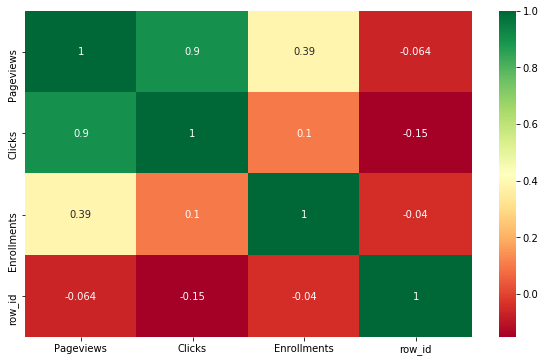

In [558]:
#get correlations of each features in dataset
corrmat = com_data1.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,6))
#plot heat map
sns.heatmap(com_data1[top_corr_features].corr(),annot=True,cmap="RdYlGn");

                 Pageviews and Clicks have some correlation with Enrollments

In [0]:
com_data1['id'] = com_data1.id.astype('category')
#com_data1['Day of Week'] = com_data1['Day of Week'].astype('category')

In [560]:
com_data1.head()

,Pageviews,Clicks,Enrollments,id,row_id,Day of Week
0,9262,727,201.0,experiment,55,"Wed,"
1,9363,736,154.0,control,17,"Tue,"
2,9871,836,156.0,control,3,"Tue,"
3,8459,691,131.0,control,8,"Sun,"
4,7716,686,105.0,experiment,37,"Sat,"


**Encode id and Day of the Week categorical variables with one-hot-encoding**

In [561]:
trains = com_data1.drop(['row_id'], axis = 1)
dummies = pd.get_dummies(data=trains[['id', 'Day of Week']], drop_first=True)
merged = pd.concat([trains, dummies], axis = 'columns')
final = merged.drop(['id', 'Day of Week'], axis = 1)
final.head()




,Pageviews,Clicks,Enrollments,id_experiment,"Day of Week_Mon,","Day of Week_Sat,","Day of Week_Sun,","Day of Week_Thu,","Day of Week_Tue,","Day of Week_Wed,"
0,9262,727,201.0,1,0,0,0,0,0,1
1,9363,736,154.0,0,0,0,0,0,1,0
2,9871,836,156.0,0,0,0,0,0,1,0
3,8459,691,131.0,0,0,0,1,0,0,0
4,7716,686,105.0,1,0,1,0,0,0,0


In [562]:
model = LinearRegression()
X = final.drop(['Enrollments'], axis = 1)
y = final['Enrollments']
X.shape

(46, 9)

In [563]:
model.fit(X,y)
model.predict([[8669, 669, 1, 0,1,0,0,0,0]])

array([156.0509139])

In [564]:
model.score(X,y)

0.5907641361934532

In [565]:
kf = KFold(n_splits=5)
kf


KFold(n_splits=5, random_state=None, shuffle=False)

In [566]:
for train_index,  test_index in kf.split(X):
  print(train_index)
  print()
  print(test_index)

[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45]

[0 1 2 3 4 5 6 7 8 9]
[ 0  1  2  3  4  5  6  7  8  9 19 20 21 22 23 24 25 26 27 28 29 30 31 32
 33 34 35 36 37 38 39 40 41 42 43 44 45]

[10 11 12 13 14 15 16 17 18]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 28 29 30 31 32
 33 34 35 36 37 38 39 40 41 42 43 44 45]

[19 20 21 22 23 24 25 26 27]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 37 38 39 40 41 42 43 44 45]

[28 29 30 31 32 33 34 35 36]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]

[37 38 39 40 41 42 43 44 45]


In [0]:
 def get_score(model, train_x, test_x, train_y, test_y):
  model.fit(train_x, train_y)
  return model.score(test_x, test_y)

In [0]:
for train_index, test_index in folds.split(X):
  train_x, test_x, train_y, test_y = X[train_index], X[test_index], y[train_index], y[test_index]